# XAI Neural Network

# Importing modules

In [ ]:
!pip install lime
!pip install shap
!pip install aix360

!pip install scikeras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/Shareddrives/DM_Project/dataset/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/DM_Project/dataset


In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import tensorflow as tf


from pandas.io.formats.style_render import DataFrame
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from math import ceil
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from scikeras.wrappers import KerasClassifier
import pickle

import lime
import lime.lime_tabular
import shap

# from aix360.metrics import faithfulness_metric, monotonicity_metric

# Loading the dataset

In [ ]:
users_extended = pd.read_csv("./users_clustering.csv")
users_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   reply_count_total       11508 non-null  float64
 7   favorite_count_total    11508 non-null  int64  
 8   num_hashtags_total      11508 non-null  int64  
 9   retweet_count_avg       11508 non-null  float64
 10  reply_count_avg         11508 non-null  float64
 11  favorite_count_avg      11508 non-null  float64
 12  num_hashtags_avg        11508 non-null  float64
 13  num_urls_avg            11508 non-null  float64
 14  num_mentions_avg        11508 non-null

In [ ]:
selected = users_extended.columns.tolist()[5:]
data = users_extended[selected]
label = users_extended["bot"]
data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [ ]:
print(data_train.shape)
print(data_test.shape)
print(label_train.shape)
print(label_test.shape)

(9206, 27)
(2302, 27)
(9206,)
(2302,)


In [ ]:
non_skewed_dists = [
 "avg_spc_len",
  "avg_len",
  "num_mentions_entropy",
  "num_hashtags_entropy",
  "favorite_count_entropy",
  "retweet_count_entropy",
  "num_mentions_std",
  "num_urls_std",
  "num_hashtags_std",
  "num_mentions_avg",
  "num_urls_avg"
]

for col in selected:
  if col not in non_skewed_dists:
    print(col)
    data.loc[:, col] = data[col].apply(lambda x: np.log10(x+1))

statuses_count
reply_count_total
favorite_count_total
num_hashtags_total
retweet_count_avg
reply_count_avg
favorite_count_avg
num_hashtags_avg
retweet_count_std
reply_count_std



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


favorite_count_std
reply_count_entropy
retweet_count_per_day
reply_count_per_day
favorite_count_per_day
num_hashtags_per_day


In [ ]:
scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

# Loading the NN model and wrap it with sciKeras

In [ ]:
data_train_scaled.shape

(9206, 27)

In [ ]:
from os import path

filename = "/content/drive/Shareddrives/DM_Project/models/model_8_16.sav"
if path.exists(filename): #loading a model saved with pickle
  print("loading from pickle")
  model = pickle.load(open(filename, 'rb'))
  pred_old = model.predict(data_train_scaled)

  model = KerasClassifier(model)
  model.initialize(data_train_scaled, label_train)
  pred = model.predict(data_train_scaled)

else: #loading a model saved with tf
  print("loading from TF")
  model = tf.keras.models.load_model('./Classification/best_NN_model8_16')
  model.summary()
  pred_old = model.predict(data_train_scaled)
  model = KerasClassifier(model)
  model.initialize(data_train_scaled, label_train)
  pred = model.predict(data_train_scaled)
  pickle.dump(model, open(filename, 'wb'))

pred_old = [1 if x>=0.5 else 0 for x in pred_old]
np.testing.assert_allclose(pred_old, pred) 

loading from pickle
288/288 [==============================] - 0s 1ms/step


#Lime explainer

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(data_train_scaled,
                                                        feature_names=users_extended.columns.tolist()[5:],
                                                        class_names=["real", "bot"],
                                                        discretize_continuous=True)

In [ ]:
exp = lime_explainer.explain_instance(data_train_scaled[0], model.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=False)

157/157 [==============================] - 0s 2ms/step


In [ ]:
exp = lime_explainer.explain_instance(data_train_scaled[0], model.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

157/157 [==============================] - 0s 1ms/step


In [ ]:
exp.local_exp

{0: [(3, 0.1290742357041734),
  (0, -0.10834280079810889),
  (20, -0.0821174137235978),
  (1, -0.08102853153411335),
  (2, 0.06513862689417527),
  (4, -0.03976000115609737),
  (12, -0.028938698754275412),
  (19, 0.025270409986010673),
  (16, 0.024917589224845778),
  (9, 0.02328134785140713)]}

# rewriting (copying) the 2 metrics since sciKeras.wrapper.KerasClassifier has problems with the shape

In [ ]:
def faithfulness_metric(model, x, coefs, base):
  """
  References:
    .. [#] `David Alvarez Melis and Tommi Jaakkola. Towards robust interpretability with self-explaining
        neural networks. In S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett, editors,
        Advances in Neural Information Processing Systems 31, pages 7775-7784. 2018.
        <https://papers.nips.cc/paper/8003-towards-robust-interpretability-with-self-explaining-neural-networks.pdf>`_

  """
  pred_class = model.predict(x.reshape(1,-1), verbose=0)[0]

  ar = np.argsort(-coefs)
  pred_probs = np.zeros(x.shape[0])
  for ind in np.nditer(ar):
      x_copy = x.copy()
      x_copy[ind] = base[ind]
      x_copy_pr = model.predict_proba(x_copy.reshape(1,-1), verbose=0)
      pred_probs[ind] = x_copy_pr[pred_class]

  return -np.corrcoef(coefs, pred_probs)[0,1]

In [ ]:
def monotonicity_metric(model, x, coefs, base):
  """ 
  References:
    .. [#] `Ronny Luss, Pin-Yu Chen, Amit Dhurandhar, Prasanna Sattigeri, Karthikeyan Shanmugam, and
        Chun-Chen Tu. Generating Contrastive Explanations with Monotonic Attribute Functions. CoRR abs/1905.13565. 2019.
        <https://arxiv.org/pdf/1905.12698.pdf>`_
  """
  pred_class = model.predict(x.reshape(1,-1), verbose=0)[0]

  x_copy = base.copy()

  #find indexs of coefficients in increasing order of value
  ar = np.argsort(coefs)
  pred_probs = np.zeros(x.shape[0])
  for ind in np.nditer(ar):
      x_copy[ind] = x[ind]
      x_copy_pr = model.predict_proba(x_copy.reshape(1,-1), verbose=0)
      pred_probs[ind] = x_copy_pr[pred_class]

  return np.all(np.diff(pred_probs[ar]) >= 0)

#Lime evaluation

In [ ]:
predicted_class = model.predict(data_train_scaled[0].reshape(1,-1))[0]

le = exp.local_exp[predicted_class]

x = data_train_scaled[0]
coefs = np.zeros(x.shape)

for v in le:
    coefs[v[0]] = v[1]

base = np.zeros(x.shape)

print("Faithfulness: ", faithfulness_metric(model, x, coefs, base))
print("Monotonity: ", monotonicity_metric(model,  x, coefs, base))

1/1 [==============================] - 0s 29ms/step
Faithfulness:  0.7626042092266714
Monotonity:  False


In [ ]:
print(type(x), x.shape)
print(type(coefs),coefs.shape)
print(type(base),base.shape)

<class 'numpy.ndarray'> (27,)
<class 'numpy.ndarray'> (27,)
<class 'numpy.ndarray'> (27,)


In [ ]:
from tqdm import tqdm
ncases = 100
fait = np.zeros(ncases)
base = np.zeros(x.shape[0])

mono = []
with tqdm(total=len(range(ncases))) as pbar:
  for i in range(ncases):
    predicted_class = model.predict(data_train_scaled[i].reshape(1,-1))[0]
    exp = lime_explainer.explain_instance(data_train_scaled[i], model.predict_proba, top_labels=1)
    le = exp.local_exp[predicted_class]
    m = exp.as_map()
    
    x = data_train.values[i]
    coefs = np.zeros(x.shape[0])
    
    for v in le:
      coefs[v[0]] = v[1]
    fait[i] = faithfulness_metric(model, data_train_scaled[i], coefs, base)
    monotone = monotonicity_metric(model,  x, coefs, base)
    mono.append(monotone)
    pbar.update(1)


mono = np.array(mono)
print("\nFaithfulness metric mean: ", np.mean(fait))
print("Faithfulness metric standard deviation:", np.std(fait))
print(f"Monotinicity: {mono.sum()}/{len(mono)}")

  0%|          | 0/100 [00:00<?, ?it/s]

157/157 [==============================] - 0s 2ms/step


  1%|          | 1/100 [00:18<30:00, 18.19s/it]

157/157 [==============================] - 0s 1ms/step


  2%|▏         | 2/100 [00:35<29:18, 17.94s/it]

157/157 [==============================] - 0s 1ms/step


  3%|▎         | 3/100 [00:53<28:32, 17.65s/it]

157/157 [==============================] - 0s 1ms/step


  4%|▍         | 4/100 [01:11<28:22, 17.74s/it]

157/157 [==============================] - 0s 1ms/step


  5%|▌         | 5/100 [01:29<28:15, 17.84s/it]

157/157 [==============================] - 0s 2ms/step


  6%|▌         | 6/100 [01:46<27:28, 17.53s/it]

157/157 [==============================] - 0s 2ms/step


  7%|▋         | 7/100 [02:04<27:47, 17.93s/it]

157/157 [==============================] - 0s 1ms/step


  8%|▊         | 8/100 [02:22<27:24, 17.88s/it]

157/157 [==============================] - 0s 1ms/step


  9%|▉         | 9/100 [02:40<27:00, 17.81s/it]

157/157 [==============================] - 0s 1ms/step


 10%|█         | 10/100 [02:57<26:34, 17.71s/it]

157/157 [==============================] - 0s 1ms/step


 11%|█         | 11/100 [03:15<26:06, 17.60s/it]

157/157 [==============================] - 0s 1ms/step


 12%|█▏        | 12/100 [03:32<25:41, 17.52s/it]

157/157 [==============================] - 0s 1ms/step


 13%|█▎        | 13/100 [03:49<25:19, 17.47s/it]

157/157 [==============================] - 0s 1ms/step


 14%|█▍        | 14/100 [04:06<24:32, 17.12s/it]

157/157 [==============================] - 0s 1ms/step


 15%|█▌        | 15/100 [04:23<24:12, 17.09s/it]

157/157 [==============================] - 0s 1ms/step


 16%|█▌        | 16/100 [04:41<24:34, 17.55s/it]

157/157 [==============================] - 0s 1ms/step


 17%|█▋        | 17/100 [04:59<24:23, 17.63s/it]

157/157 [==============================] - 0s 1ms/step


 18%|█▊        | 18/100 [05:17<24:05, 17.63s/it]

157/157 [==============================] - 0s 1ms/step


 19%|█▉        | 19/100 [05:34<23:32, 17.43s/it]

157/157 [==============================] - 0s 1ms/step


 20%|██        | 20/100 [05:51<23:20, 17.51s/it]

157/157 [==============================] - 0s 1ms/step


 21%|██        | 21/100 [06:09<23:10, 17.61s/it]

157/157 [==============================] - 0s 1ms/step


 22%|██▏       | 22/100 [06:27<22:51, 17.58s/it]

157/157 [==============================] - 0s 2ms/step


 23%|██▎       | 23/100 [06:45<22:41, 17.68s/it]

157/157 [==============================] - 0s 1ms/step


 24%|██▍       | 24/100 [07:02<22:28, 17.74s/it]

157/157 [==============================] - 0s 1ms/step


 25%|██▌       | 25/100 [07:19<21:48, 17.45s/it]

157/157 [==============================] - 0s 2ms/step


 26%|██▌       | 26/100 [07:37<21:29, 17.43s/it]

157/157 [==============================] - 0s 1ms/step


 27%|██▋       | 27/100 [07:54<21:01, 17.28s/it]

157/157 [==============================] - 0s 2ms/step


 28%|██▊       | 28/100 [08:11<20:50, 17.37s/it]

157/157 [==============================] - 0s 1ms/step


 29%|██▉       | 29/100 [08:28<20:16, 17.14s/it]

157/157 [==============================] - 0s 1ms/step


 30%|███       | 30/100 [08:45<20:07, 17.26s/it]

157/157 [==============================] - 0s 1ms/step


 31%|███       | 31/100 [09:03<19:50, 17.25s/it]

157/157 [==============================] - 0s 1ms/step


 32%|███▏      | 32/100 [09:20<19:34, 17.28s/it]

157/157 [==============================] - 0s 2ms/step


 33%|███▎      | 33/100 [09:38<19:41, 17.64s/it]

157/157 [==============================] - 0s 1ms/step


 34%|███▍      | 34/100 [09:56<19:17, 17.54s/it]

157/157 [==============================] - 0s 1ms/step


 35%|███▌      | 35/100 [10:12<18:44, 17.30s/it]

157/157 [==============================] - 0s 1ms/step


 36%|███▌      | 36/100 [10:30<18:25, 17.27s/it]

157/157 [==============================] - 0s 1ms/step


 37%|███▋      | 37/100 [10:46<17:55, 17.07s/it]

157/157 [==============================] - 0s 1ms/step


 38%|███▊      | 38/100 [11:04<17:47, 17.22s/it]

157/157 [==============================] - 0s 1ms/step


 39%|███▉      | 39/100 [11:21<17:28, 17.18s/it]

157/157 [==============================] - 0s 2ms/step


 40%|████      | 40/100 [11:38<17:08, 17.13s/it]

157/157 [==============================] - 0s 3ms/step


 41%|████      | 41/100 [11:57<17:26, 17.73s/it]

157/157 [==============================] - 0s 1ms/step


 42%|████▏     | 42/100 [12:14<16:52, 17.46s/it]

157/157 [==============================] - 0s 2ms/step


 43%|████▎     | 43/100 [12:30<16:19, 17.18s/it]

157/157 [==============================] - 0s 1ms/step


 44%|████▍     | 44/100 [12:48<16:02, 17.19s/it]

157/157 [==============================] - 0s 1ms/step


 45%|████▌     | 45/100 [13:05<15:52, 17.32s/it]

157/157 [==============================] - 0s 1ms/step


 46%|████▌     | 46/100 [13:23<15:41, 17.43s/it]

157/157 [==============================] - 0s 1ms/step


 47%|████▋     | 47/100 [13:41<15:31, 17.57s/it]

157/157 [==============================] - 0s 2ms/step


 48%|████▊     | 48/100 [13:57<14:56, 17.25s/it]

157/157 [==============================] - 0s 1ms/step


 49%|████▉     | 49/100 [14:14<14:27, 17.02s/it]

157/157 [==============================] - 0s 1ms/step


 50%|█████     | 50/100 [14:32<14:24, 17.29s/it]

157/157 [==============================] - 0s 1ms/step


 51%|█████     | 51/100 [14:48<13:53, 17.01s/it]

157/157 [==============================] - 0s 1ms/step


 52%|█████▏    | 52/100 [15:06<13:44, 17.17s/it]

157/157 [==============================] - 0s 2ms/step


 53%|█████▎    | 53/100 [15:23<13:24, 17.13s/it]

157/157 [==============================] - 0s 1ms/step


 54%|█████▍    | 54/100 [15:40<13:16, 17.31s/it]

157/157 [==============================] - 0s 1ms/step


 55%|█████▌    | 55/100 [15:57<12:54, 17.22s/it]

157/157 [==============================] - 0s 1ms/step


 56%|█████▌    | 56/100 [16:16<12:49, 17.50s/it]

157/157 [==============================] - 0s 1ms/step


 57%|█████▋    | 57/100 [16:32<12:22, 17.26s/it]

157/157 [==============================] - 0s 2ms/step


 58%|█████▊    | 58/100 [16:52<12:31, 17.90s/it]

157/157 [==============================] - 0s 1ms/step


 59%|█████▉    | 59/100 [17:09<12:04, 17.68s/it]

157/157 [==============================] - 0s 1ms/step


 60%|██████    | 60/100 [17:26<11:42, 17.56s/it]

157/157 [==============================] - 0s 1ms/step


 61%|██████    | 61/100 [17:43<11:21, 17.47s/it]

157/157 [==============================] - 0s 1ms/step


 62%|██████▏   | 62/100 [18:00<10:58, 17.32s/it]

157/157 [==============================] - 0s 1ms/step


 63%|██████▎   | 63/100 [18:18<10:41, 17.33s/it]

157/157 [==============================] - 0s 1ms/step


 64%|██████▍   | 64/100 [18:35<10:20, 17.24s/it]

157/157 [==============================] - 0s 1ms/step


 65%|██████▌   | 65/100 [18:52<10:05, 17.31s/it]

157/157 [==============================] - 0s 2ms/step


 66%|██████▌   | 66/100 [19:10<09:54, 17.48s/it]

157/157 [==============================] - 0s 1ms/step


 67%|██████▋   | 67/100 [19:29<09:52, 17.96s/it]

157/157 [==============================] - 0s 1ms/step


 68%|██████▊   | 68/100 [19:47<09:33, 17.91s/it]

157/157 [==============================] - 0s 2ms/step


 69%|██████▉   | 69/100 [20:03<09:01, 17.46s/it]

157/157 [==============================] - 0s 2ms/step


 70%|███████   | 70/100 [20:20<08:35, 17.19s/it]

157/157 [==============================] - 0s 2ms/step


 71%|███████   | 71/100 [20:38<08:22, 17.33s/it]

157/157 [==============================] - 0s 1ms/step


 72%|███████▏  | 72/100 [20:54<07:58, 17.09s/it]

157/157 [==============================] - 0s 1ms/step


 73%|███████▎  | 73/100 [21:11<07:38, 17.00s/it]

157/157 [==============================] - 0s 1ms/step


 74%|███████▍  | 74/100 [21:29<07:28, 17.24s/it]

157/157 [==============================] - 0s 2ms/step


 75%|███████▌  | 75/100 [21:48<07:23, 17.72s/it]

157/157 [==============================] - 0s 2ms/step


 76%|███████▌  | 76/100 [22:05<07:07, 17.80s/it]

157/157 [==============================] - 0s 2ms/step


 77%|███████▋  | 77/100 [22:23<06:48, 17.74s/it]

157/157 [==============================] - 0s 1ms/step


 78%|███████▊  | 78/100 [22:41<06:28, 17.64s/it]

157/157 [==============================] - 0s 1ms/step


 79%|███████▉  | 79/100 [22:58<06:11, 17.69s/it]

157/157 [==============================] - 0s 2ms/step


 80%|████████  | 80/100 [23:16<05:50, 17.55s/it]

157/157 [==============================] - 0s 2ms/step


 81%|████████  | 81/100 [23:33<05:35, 17.65s/it]

157/157 [==============================] - 0s 1ms/step


 82%|████████▏ | 82/100 [23:51<05:16, 17.58s/it]

157/157 [==============================] - 0s 1ms/step


 83%|████████▎ | 83/100 [24:09<05:03, 17.83s/it]

157/157 [==============================] - 0s 2ms/step


 84%|████████▍ | 84/100 [24:27<04:45, 17.86s/it]

157/157 [==============================] - 0s 2ms/step


 85%|████████▌ | 85/100 [24:44<04:24, 17.63s/it]

157/157 [==============================] - 0s 2ms/step


 86%|████████▌ | 86/100 [25:02<04:05, 17.52s/it]

157/157 [==============================] - 0s 1ms/step


 87%|████████▋ | 87/100 [25:19<03:47, 17.52s/it]

157/157 [==============================] - 0s 2ms/step


 88%|████████▊ | 88/100 [25:36<03:29, 17.44s/it]

157/157 [==============================] - 0s 2ms/step


 89%|████████▉ | 89/100 [25:54<03:12, 17.47s/it]

157/157 [==============================] - 0s 2ms/step


 90%|█████████ | 90/100 [26:11<02:53, 17.32s/it]

157/157 [==============================] - 0s 2ms/step


 91%|█████████ | 91/100 [26:28<02:35, 17.24s/it]

157/157 [==============================] - 0s 2ms/step


 92%|█████████▏| 92/100 [26:46<02:20, 17.52s/it]

157/157 [==============================] - 0s 1ms/step


 93%|█████████▎| 93/100 [27:04<02:03, 17.61s/it]

157/157 [==============================] - 0s 2ms/step


 94%|█████████▍| 94/100 [27:22<01:45, 17.62s/it]

157/157 [==============================] - 0s 1ms/step


 95%|█████████▌| 95/100 [27:39<01:28, 17.66s/it]

157/157 [==============================] - 0s 2ms/step


 96%|█████████▌| 96/100 [27:57<01:10, 17.68s/it]

157/157 [==============================] - 0s 2ms/step


 97%|█████████▋| 97/100 [28:14<00:52, 17.60s/it]

157/157 [==============================] - 0s 2ms/step


 98%|█████████▊| 98/100 [28:32<00:35, 17.53s/it]

157/157 [==============================] - 0s 2ms/step


 99%|█████████▉| 99/100 [28:49<00:17, 17.49s/it]

157/157 [==============================] - 0s 2ms/step


100%|██████████| 100/100 [29:08<00:00, 17.48s/it]


Faithfulness metric mean:  0.6337300632895702
Faithfulness metric standard deviation: 0.1648884126170493
Monotinicity: 43/100


#Shap explainer


In [ ]:
shap_test_set = data_test_scaled[:50]

In [ ]:
f = lambda X : model.predict_proba(X).reshape(len(X), 2)
nn_explainer = shap.KernelExplainer(f, shap_test_set)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# nn_explainer = shap.DeepExplainer((tf_model.layers[0].input, tf_model.layers[-1].output), shap_test_set)
shap_values = nn_explainer.shap_values(shap_test_set)

  0%|          | 0/50 [00:00<?, ?it/s]

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 6s 2ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 6s 2ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 7s 2ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1/1 [==============================] - 0s 20ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1/1 [==============================] - 0s 17ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

1/1 [==============================] - 0s 19ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 4s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 6s 2ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

3285/3285 [==============================] - 5s 1ms/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

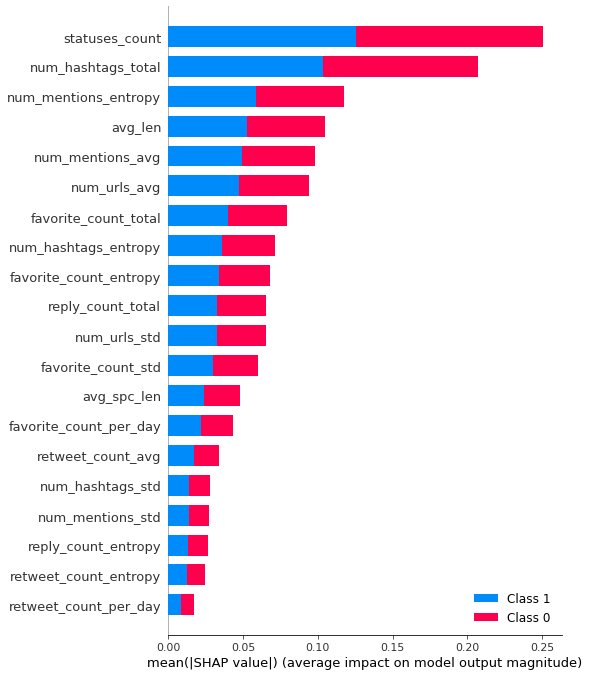

In [ ]:
shap.summary_plot(shap_values, shap_test_set, data_train.columns)

In [ ]:
shap.initjs()
shap.force_plot(nn_explainer.expected_value[0], shap_values[0][0], feature_names=data_train.columns)

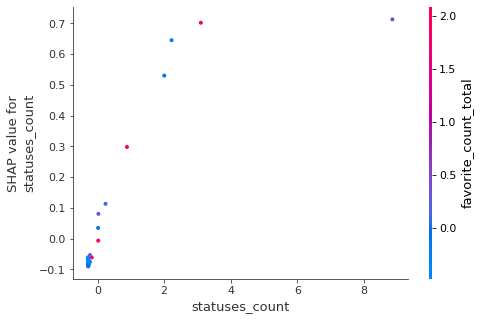

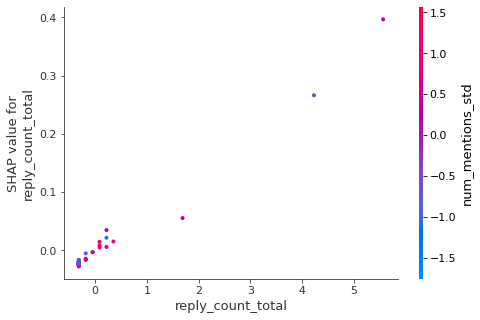

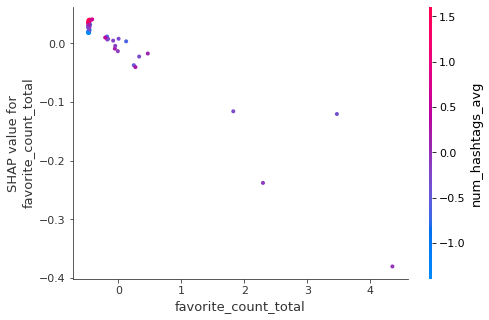

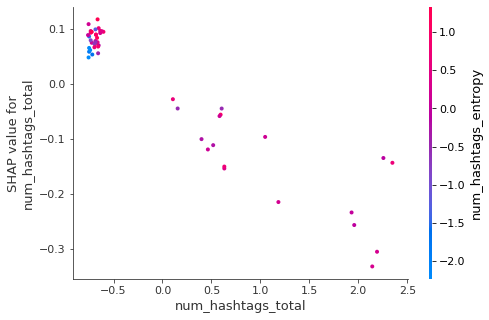

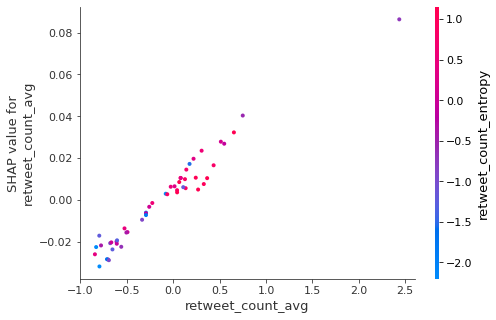

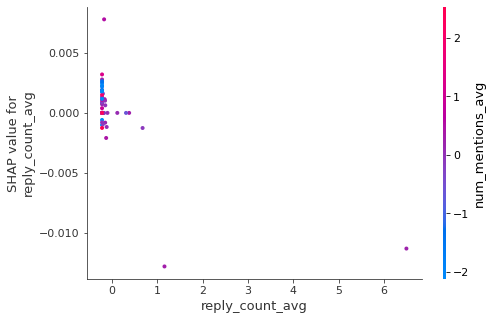

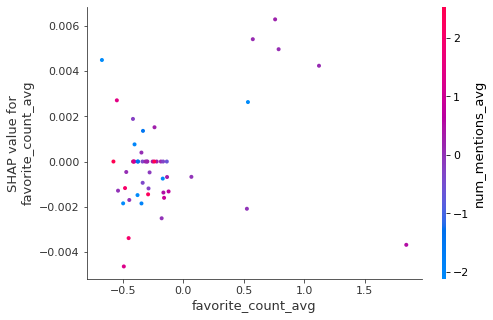

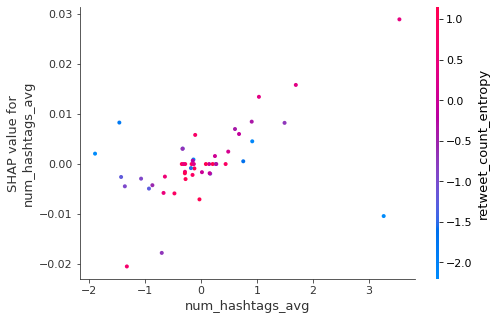

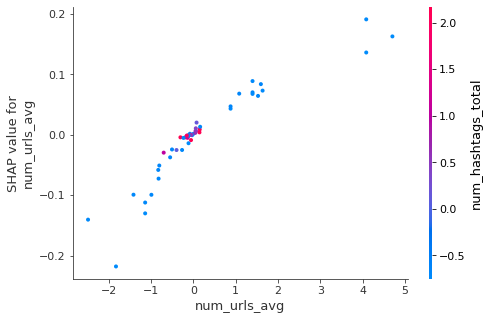

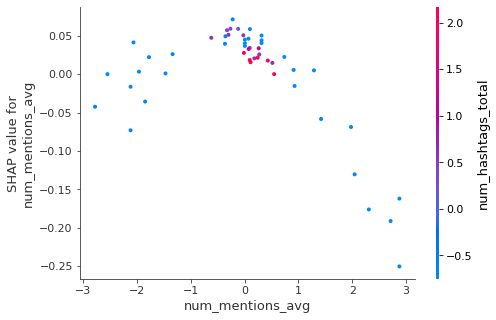

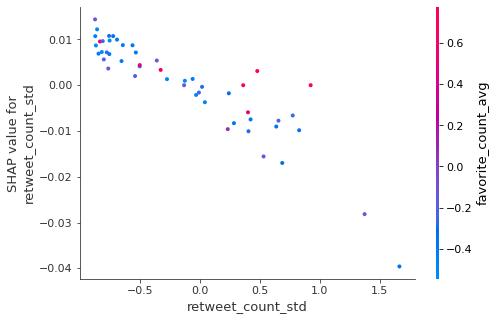

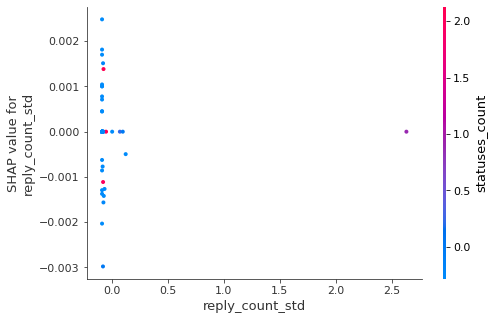

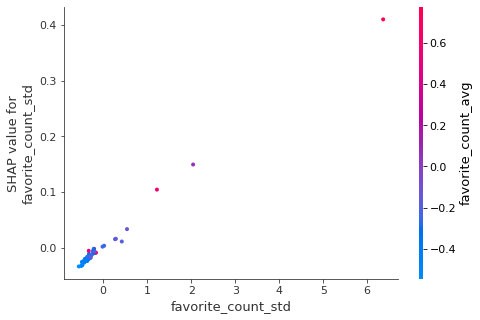

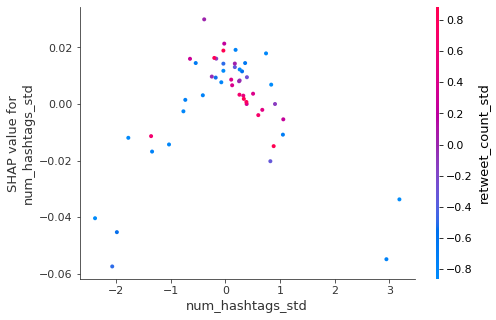

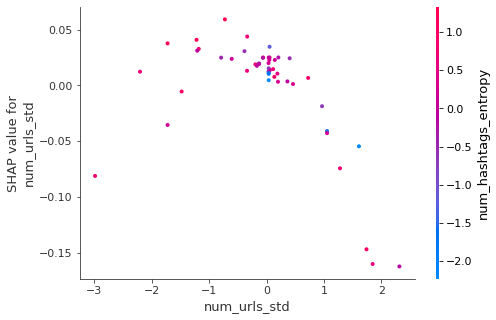

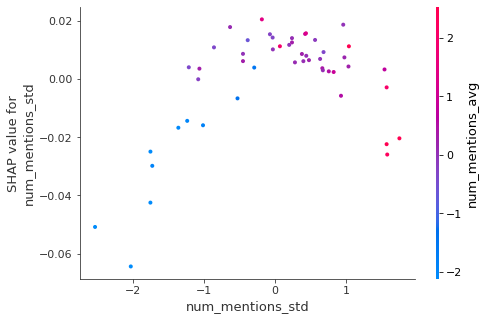

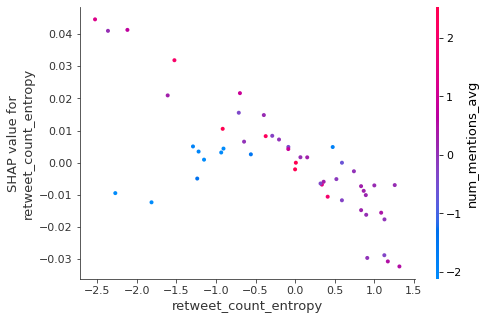

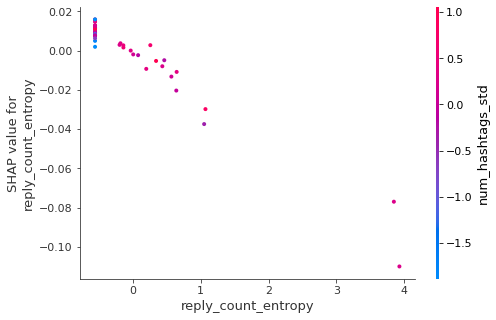

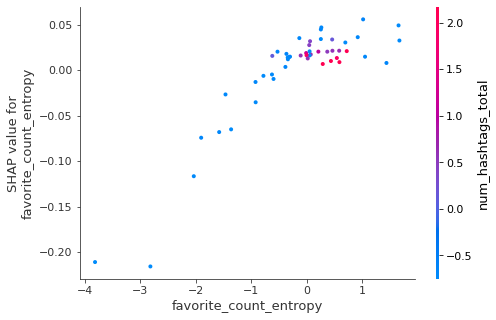

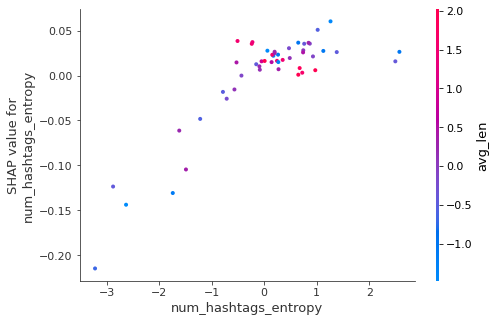

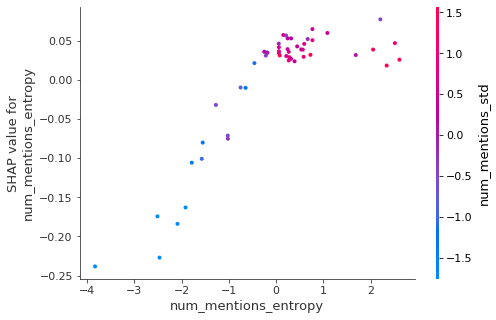

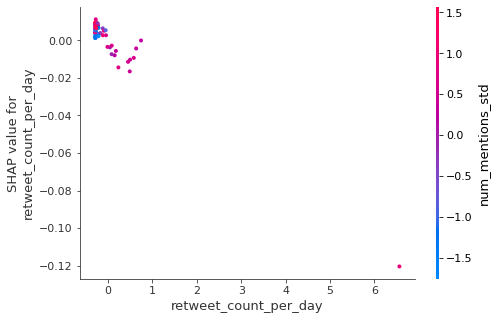

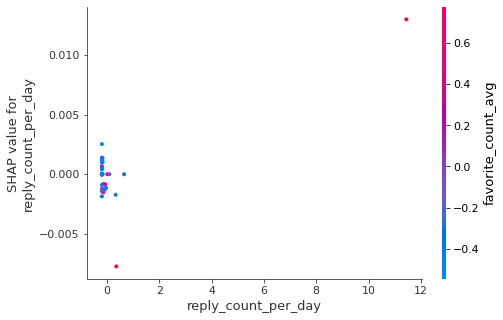

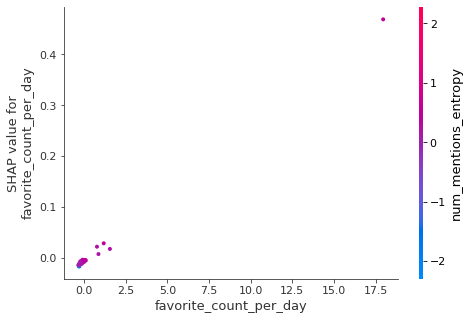

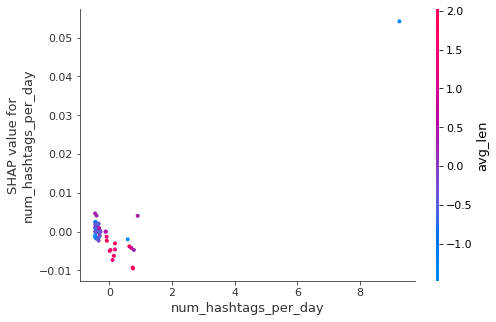

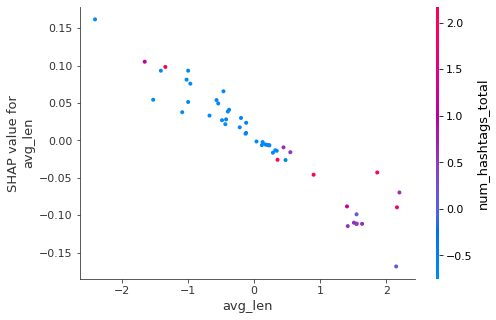

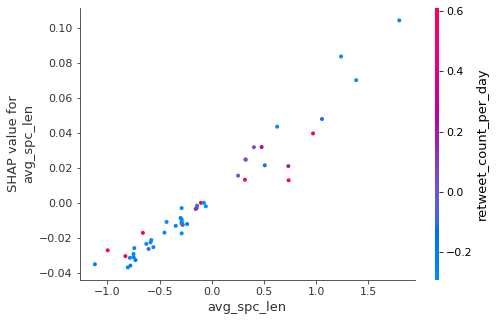

In [ ]:
for name in data_train.columns:
  shap.dependence_plot(name, shap_values[0], shap_test_set,  feature_names=data_train.columns, interaction_index=None)

In [ ]:
shap.initjs()
shap.force_plot(nn_explainer.expected_value[0], shap_values[0], shap_test_set, feature_names=data_train.columns)

#SHAP evaluation

In [ ]:
predicted_class = model.predict(data_test_scaled[0].reshape(1,-1))[0]

x = data_test_scaled[0]

base = np.zeros(x.shape[0])

print("Faithfulness: ", faithfulness_metric(model, x, shap_values[predicted_class], base))
print("Monotonity: ", monotonicity_metric(model, x, shap_values[predicted_class], base))

1/1 [==============================] - 0s 39ms/step
Faithfulness:  0.1597046722522789
Monotonity:  True


In [ ]:
ncases = 100
fait = np.zeros(ncases)
mono = []

with tqdm(total=len(range(ncases))) as pbar:
  for i in range(ncases):
    predicted_class = model.predict(data_test_scaled[i].reshape(1,-1))[0]
    fait[i] = faithfulness_metric(model, data_test_scaled[i], shap_values[predicted_class], base)
    monotone = monotonicity_metric(model, x, shap_values[predicted_class], base)
    mono.append(monotone)
    pbar.update(1)

mono = np.array(mono)
print("\nFaithfulness metric mean: ", np.mean(fait))
print("Faithfulness metric standard deviation:", np.std(fait))
print(f"Monotinicity: {mono.sum()}/{len(mono)}")

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/100 [02:27<4:03:25, 147.53s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 2/100 [04:56<4:01:53, 148.10s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 3/100 [07:23<3:58:55, 147.79s/it]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [09:49<3:55:22, 147.11s/it]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 5/100 [12:15<3:52:07, 146.61s/it]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [14:43<3:50:36, 147.20s/it]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 7/100 [17:12<3:49:10, 147.86s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [19:50<3:51:21, 150.89s/it]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 9/100 [22:21<3:49:16, 151.17s/it]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [24:53<3:46:50, 151.23s/it]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 11/100 [27:20<3:42:22, 149.91s/it]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 12/100 [29:46<3:38:12, 148.78s/it]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 13/100 [32:09<3:33:19, 147.12s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 14/100 [34:32<3:29:05, 145.87s/it]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 15/100 [36:53<3:24:21, 144.25s/it]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [39:17<3:22:03, 144.33s/it]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 17/100 [41:42<3:20:00, 144.59s/it]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [44:05<3:16:50, 144.03s/it]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 19/100 [46:31<3:15:03, 144.49s/it]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 20/100 [48:56<3:12:57, 144.72s/it]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 21/100 [51:21<3:10:41, 144.83s/it]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 22/100 [53:46<3:08:09, 144.74s/it]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 23/100 [56:12<3:06:34, 145.38s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 24/100 [58:39<3:04:44, 145.85s/it]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 25/100 [1:01:03<3:01:24, 145.12s/it]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [1:03:30<2:59:37, 145.64s/it]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 27/100 [1:05:54<2:56:36, 145.16s/it]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 28/100 [1:08:17<2:53:30, 144.60s/it]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 29/100 [1:10:42<2:51:07, 144.62s/it]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [1:13:10<2:49:52, 145.61s/it]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 31/100 [1:15:40<2:48:56, 146.91s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 32/100 [1:18:09<2:47:31, 147.82s/it]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 33/100 [1:20:40<2:45:58, 148.63s/it]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [1:23:08<2:43:12, 148.37s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 35/100 [1:25:35<2:40:30, 148.16s/it]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [1:28:04<2:38:00, 148.13s/it]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 37/100 [1:30:31<2:35:17, 147.89s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 38/100 [1:32:59<2:32:46, 147.84s/it]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 39/100 [1:35:28<2:30:49, 148.35s/it]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [1:37:56<2:28:16, 148.28s/it]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 41/100 [1:40:26<2:26:20, 148.82s/it]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [1:42:52<2:22:59, 147.92s/it]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 43/100 [1:45:20<2:20:26, 147.83s/it]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [1:47:48<2:18:11, 148.06s/it]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 45/100 [1:50:17<2:15:59, 148.36s/it]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [1:52:45<2:13:12, 148.01s/it]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 47/100 [1:55:14<2:11:05, 148.40s/it]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 48/100 [1:57:42<2:08:30, 148.28s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 49/100 [2:00:09<2:05:41, 147.87s/it]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 50/100 [2:02:38<2:03:28, 148.16s/it]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 51/100 [2:05:05<2:00:44, 147.85s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 52/100 [2:07:33<1:58:18, 147.89s/it]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 53/100 [2:10:02<1:56:13, 148.37s/it]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [2:12:30<1:53:33, 148.11s/it]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 55/100 [2:14:56<1:50:37, 147.49s/it]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 56/100 [2:17:22<1:47:54, 147.14s/it]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 57/100 [2:19:49<1:45:28, 147.19s/it]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [2:22:17<1:43:02, 147.19s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 59/100 [2:24:45<1:40:53, 147.65s/it]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [2:27:15<1:38:48, 148.22s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 61/100 [2:29:41<1:35:57, 147.62s/it]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [2:32:07<1:33:12, 147.18s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 63/100 [2:34:35<1:30:55, 147.45s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 64/100 [2:37:04<1:28:37, 147.72s/it]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 65/100 [2:39:34<1:26:40, 148.58s/it]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 66/100 [2:42:01<1:23:56, 148.13s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 67/100 [2:44:32<1:21:54, 148.92s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 68/100 [2:47:02<1:19:35, 149.24s/it]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 69/100 [2:49:33<1:17:18, 149.63s/it]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [2:51:59<1:14:23, 148.78s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 71/100 [2:54:29<1:11:57, 148.90s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 72/100 [2:56:54<1:08:57, 147.79s/it]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 73/100 [2:59:21<1:06:26, 147.65s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [3:01:50<1:04:10, 148.09s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 75/100 [3:04:21<1:02:03, 148.95s/it]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [3:06:50<59:32, 148.85s/it]  

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 77/100 [3:09:16<56:48, 148.18s/it]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 78/100 [3:11:44<54:14, 147.95s/it]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 79/100 [3:14:14<51:57, 148.48s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 80/100 [3:16:42<49:28, 148.41s/it]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 81/100 [3:19:11<47:03, 148.63s/it]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [3:21:41<44:40, 148.93s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 83/100 [3:24:09<42:08, 148.75s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [3:26:38<39:39, 148.70s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 85/100 [3:29:04<37:02, 148.16s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 86/100 [3:31:35<34:45, 148.95s/it]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 87/100 [3:34:04<32:15, 148.86s/it]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [3:36:31<29:41, 148.49s/it]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 89/100 [3:39:00<27:13, 148.46s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 90/100 [3:41:29<24:46, 148.69s/it]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 91/100 [3:43:59<22:21, 149.04s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 92/100 [3:46:21<19:35, 146.90s/it]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 93/100 [3:48:47<17:07, 146.75s/it]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [3:51:14<14:41, 146.89s/it]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 95/100 [3:53:41<12:14, 146.83s/it]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [3:56:07<09:46, 146.67s/it]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 97/100 [3:58:32<07:18, 146.15s/it]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 98/100 [4:00:55<04:49, 144.99s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 99/100 [4:03:19<02:24, 144.71s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 100/100 [4:05:41<00:00, 147.42s/it]


Faithfulness metric mean:  0.1597046719154349
Faithfulness metric standard deviation: 4.2127085180027955e-10
Monotinicity: 100/100
